# Stefano Quaggio

## Packages

In [1]:
import networkx as nx # For graphs
import pickle # For data parsing
from networkx.algorithms.approximation import greedy_tsp # For approx TSP
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import math
from torch import Tensor
import time
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

## Helper functions

In [2]:
def tour_length(G: nx.Graph, tour: List[int]):
    """
    Compute the length of a tour in the graph
    
    Args:
        - G: Graph
        - tour: The tour as a list of node indices
    
    Returns:
        - The length of the tour
    """
    n = len(tour) - 1
    assert tour[0] == tour[-1], "Not a valid tour"
    estimated = 0
    
    for i in range(n):
        estimated += G[tour[i]][tour[i + 1]]['weight']
    return estimated

def greedy_algorithm(G: nx.Graph):
    """
    Run the greedy approximation algorithm on the graph
    
    Args:
        - G: Graph
    
    Returns:
        - The length of the tour found by the greedy algorithm
    """
    return tour_length(G, greedy_tsp(G, weight='weight'))

def random_tour(G: nx.Graph, seed: int = 42) -> float:
    """
    Generate a random tour and compute its length
    
    Args:
        -  G: Graph
        -  seed: Random seed for reproducibility
    
    Returns:
        - The length of the random tour
    """
    np.random.seed(seed)
    n = G.number_of_nodes()
    tour = [0]
    for i in range(1, n):
        next_node = np.random.choice([j for j in range(n) if j not in tour])
        tour.append(next_node)
    tour.append(0)
    return tour_length(G, tour)

def transformer_tsp(G: nx.Graph, model: nn.Module, DEVICE: str = 'cpu'):
    """
    Evaluate the trained model on the graph 
    
    Args:
        - G: Graph
        - model: The trained TSP Transformer model
        - DEVICE: Devicce (CPU/GPU/MPS)
    
    Returns:
        - The length of the tour found by the model
    """
    model.eval()

    n = G.number_of_nodes()

    # Get node coordinates
    attr = nx.get_node_attributes(G, 'pos')
    x = []
    for i in range(n):
        x.append(torch.tensor(attr[i], dtype=torch.float32))

    # From list of tensors to tensor 2d
    x = torch.stack(x)

    tour = [0]
    y = torch.tensor(tour, dtype=torch.long)
    x = x.to(DEVICE).unsqueeze(0)
    y = y.to(DEVICE).unsqueeze(0)

    with torch.no_grad():
        _, tgt_mask, _, _ = create_mask(x, y)

        out = model(x, y, None, tgt_mask, None, None)

        # Loop until the tour is complete
        while len(tour) < n:
            _, idx = torch.topk(out, n, dim=2)
            for i in range(n):
                # Check if the node is already in the tour
                if idx[0, -1, i] not in tour:
                    tour.append(idx[0, -1, i])
                    break
            y = torch.tensor(tour)
            y = y.to(DEVICE).unsqueeze(0)

            tgt_seq_len = y.shape[1]

            tgt_mask = generate_square_subsequent_mask(tgt_seq_len)

            out = model(x, y, None, tgt_mask, None, None)

    tour = [int(i) for i in tour] + [0]  # Append the starting node (hard-coded to 0)

    return tour_length(G, tour)

def compute_gap(G: nx.Graph, model = None, model_GA = None, 
                random_seed: int = 42, device: str = 'cpu'):
    """
    Compute the gap between the optimal solution on graph G and all the analyzed methods
    
    Args:
        - G: Graph
        - model: The trained TSP Transformer model
        - model_GA: The trained TSP Transformer model with gradient accumulation
        - random_seed: Random seed for reproducibility
        - device: The device to run the model on
    
    Returns:
        - A dictionary containing the gaps for each method
    """
    # Optimal value (hard-coded in the graph)
    TSP = sum([G[i][j]['weight'] * G[i][j]['tour'] for (i, j) in G.edges()])  # Optimal

    # Gaps dictionary
    gaps = {'greedy': 0, 'random': 0, 'transformer_tsp': 0, 'transformer_tsp_acc_grad': 0}
    gaps['greedy'] = 100 * (greedy_algorithm(G) - TSP) / TSP
    gaps['random'] = 100 * (random_tour(G, random_seed) - TSP) / TSP
    if model is not None:
        gaps['transformer_tsp'] = 100 * (transformer_tsp(G, model, DEVICE=device) - TSP) / TSP
    else:
        gaps['transformer_tsp'] = float('inf')  # In case you just train with GA

    if model_GA is not None:
        gaps['transformer_tsp_acc_grad'] = 100 * (transformer_tsp(G, model_GA, DEVICE=device) - TSP) / TSP
    else:
        gaps['transformer_tsp_acc_grad'] = float('inf')  # In case you just train without GA

    return gaps

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

## Dataset & Dataloader

In [4]:
class TSPDataset(Dataset):
    def __init__(self, data_path: str):
        with open(data_path, 'rb') as f:
            self.data = pickle.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        """
        Retrieve a sample from the dataset at the specified index
        
        Args:
            - index: Index of the sample to retrieve
        
        Returns:
            - A tuple containing the node positions (X) and the tour (y)
        """
        graph, tour = self.data[index]

        # Extract node positions from the graph
        pos = nx.get_node_attributes(graph, 'pos')

        # Convert positions dictionary to a tensor
        # Ensure nodes are ordered from 0 to 19
        X = torch.tensor([pos[i] for i in range(20)], dtype=torch.float32)

        # Convert tour to tensor
        y = torch.tensor(tour, dtype=torch.long)

        return X, y

In [5]:
def load_dummy_dataset(data_path: str = '/kaggle/input/graphset/dummy_20_DLL_ass4.pkl'):
    """
    Load a dummy dataset and print basic information about the graph
    
    Args:
        - data_path: Path to the pickle file containing the dataset
    
    Returns:
        - A tuple containing the graph and the tour
    """
    with open(data_path, 'rb') as f:
        dummy_data = pickle.load(f)

    graph, tour = dummy_data[0]

    # Basic information
    print("=== Basic Graph Information ===")
    print(f"Data type information:")
    print(f"- Graph type: {type(graph)}")
    print(f"- Tour type: {type(tour)}")

    # Detailed graph analysis
    print("\n=== Detailed Graph Analysis ===")
    print(f"- Number of nodes: {graph.number_of_nodes()}")
    print(f"- Number of edges: {graph.number_of_edges()}")
    print(f"- Is directed: {graph.is_directed()}")
    print(f"- Is weighted: {any('weight' in d for _, _, d in graph.edges(data=True))}")

    # Node attributes
    print("\n=== Node Attributes ===")
    sample_node = list(graph.nodes(data=True))[0]
    print(f"- Sample node attributes: {sample_node}")

    # Edge analysis
    if graph.number_of_edges() > 0:
        print("\n=== Edge Analysis ===")
        sample_edge = list(graph.edges(data=True))[0]
        print(f"- Sample edge attributes: {sample_edge}")

    return dummy_data[0]

Load dummy dataset

In [6]:
folder_path = '/kaggle/input/graphset'

In [7]:
graph, tour = load_dummy_dataset(f"{folder_path}/dummy_20_DLL_ass4.pkl")

=== Basic Graph Information ===
Data type information:
- Graph type: <class 'networkx.classes.graph.Graph'>
- Tour type: <class 'list'>

=== Detailed Graph Analysis ===
- Number of nodes: 20
- Number of edges: 190
- Is directed: False
- Is weighted: True

=== Node Attributes ===
- Sample node attributes: (0, {'pos': (0.6049077053425551, 0.5748590937018008)})

=== Edge Analysis ===
- Sample edge attributes: (0, 1, {'weight': 0.4287846201876535, 'tour': 0})


Print graph information

In [8]:
print("Tour edge: ", nx.get_edge_attributes(graph, 'tour'))
print("Weight edge: ", nx.get_edge_attributes(graph, 'weight'))
print("Pos: ", nx.get_node_attributes(graph, 'pos'))

Tour edge:  {(0, 1): 0, (0, 2): 0, (0, 3): 1, (0, 4): 1, (0, 5): 0, (0, 6): 0, (0, 7): 0, (0, 8): 0, (0, 9): 0, (0, 10): 0, (0, 11): 0, (0, 12): 0, (0, 13): 0, (0, 14): 0, (0, 15): 0, (0, 16): 0, (0, 17): 0, (0, 18): 0, (0, 19): 0, (1, 2): 0, (1, 3): 0, (1, 4): 1, (1, 5): 0, (1, 6): 0, (1, 7): 0, (1, 8): 0, (1, 9): 0, (1, 10): 0, (1, 11): 0, (1, 12): 0, (1, 13): 0, (1, 14): 0, (1, 15): 1, (1, 16): 0, (1, 17): 0, (1, 18): 0, (1, 19): 0, (2, 3): 0, (2, 4): 0, (2, 5): 0, (2, 6): 0, (2, 7): 0, (2, 8): 0, (2, 9): 1, (2, 10): 0, (2, 11): 0, (2, 12): 0, (2, 13): 0, (2, 14): 1, (2, 15): 0, (2, 16): 0, (2, 17): 0, (2, 18): 0, (2, 19): 0, (3, 4): 0, (3, 5): 0, (3, 6): 0, (3, 7): 0, (3, 8): 0, (3, 9): 0, (3, 10): 0, (3, 11): 0, (3, 12): 0, (3, 13): 0, (3, 14): 1, (3, 15): 0, (3, 16): 0, (3, 17): 0, (3, 18): 0, (3, 19): 0, (4, 5): 0, (4, 6): 0, (4, 7): 0, (4, 8): 0, (4, 9): 0, (4, 10): 0, (4, 11): 0, (4, 12): 0, (4, 13): 0, (4, 14): 0, (4, 15): 0, (4, 16): 0, (4, 17): 0, (4, 18): 0, (4, 19): 0, (5

Dataset class and DataLoader

In [9]:
batch_size = 32
dataset_train = TSPDataset(f"{folder_path}/train_20_DLL_ass4.pkl")
dataset_valid = TSPDataset(f"{folder_path}/valid_20_DLL_ass4.pkl")
dataset_test = TSPDataset(f"{folder_path}/test_20_DLL_ass4.pkl")

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

## Model

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        """
        Initialize the positional encoding module.
        
        Args:
            - emb_size: The size of the embedding dimension.
            - dropout: Dropout probability.
            - maxlen: Maximum length of the sequence.
        """
        super(PositionalEncoding, self).__init__()

        den = torch.exp(- torch.arange(0, emb_size, 2, device=DEVICE) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen, device=DEVICE).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size), device=DEVICE)
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        """
        Apply positional encoding to the input token embeddings
        
        Args:
            - token_embedding: Input token embeddings
        
        Returns:
            - Token embeddings with positional encoding applied
        """
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TSPTransformer(nn.Module):
    def __init__(self, n_nodes: int = 20, d_e: int = 120, d_d: int = 120, nhead: int = 10, 
                 num_encoder_layers: int = 6, num_decoder_layers: int = 6, 
                 dim_feedforward: int = 512, dropout: float = 0.2):
        """
        Initialize the TSP Transformer model.
        
        Args:
           - n_nodes: Number of nodes in the TSP graph
           - d_e: Dimension of the encoder embeddings
           - d_d: Dimension of the decoder embeddings
           - nhead: Number of attention heads
           - num_encoder_layers: Number of encoder layers
           - num_decoder_layers: Number of decoder layers
           - dim_feedforward: Dimension of the feedforward network
           - dropout: Dropout value
        """
        super().__init__()

        self.input_linear = nn.Linear(2, d_e)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_e, nhead, dim_feedforward, dropout, batch_first=True),
            num_encoder_layers
        )

        self.linear = nn.Linear(d_e, d_d)
        self.embedding = nn.Embedding(n_nodes, d_d)
        self.positional_encoding = PositionalEncoding(d_d, dropout)

        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_d, nhead, dim_feedforward, dropout, batch_first=True),
            num_decoder_layers
        )

        self.output_linear = nn.Sequential(
            nn.Linear(d_e, d_d),
            nn.ReLU(),
            nn.Linear(d_d, n_nodes)
        )

    def forward(self, src: Tensor, trg: Tensor, src_mask: Tensor, tgt_mask: Tensor, 
                src_padding_mask: Tensor, tgt_padding_mask: Tensor):
        """
        Args:
           - src: Source sequence (node positions)
           - trg: Target sequence (tour)
           - src_mask: Source mask
           - tgt_mask: Target mask
           - src_padding_mask: Source padding mask
           - tgt_padding_mask: Target padding mask

        
        Returns:
            - Output predictions
        """

        src = self.input_linear(src)
        trg = self.embedding(trg)
        trg = self.positional_encoding(trg)

        src = self.encoder(src, mask=src_mask, src_key_padding_mask=src_padding_mask)

        memory = self.linear(src)

        output = self.decoder(trg, memory, tgt_mask=tgt_mask, memory_mask=None,
                            tgt_key_padding_mask=tgt_padding_mask,
                            memory_key_padding_mask=src_padding_mask)
        output = self.output_linear(output)

        return output

In [11]:
model = TSPTransformer().to(DEVICE)

## Training

In [12]:
def generate_square_subsequent_mask(sequence_length: int):
    """
    Generate a square subsequent mask for the transformer
    
    Args:
        - sequence_length: Length of the sequence
    
    Returns:
        - The generated mask
    """
    mask = (torch.triu(torch.ones((sequence_length, sequence_length), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src: Tensor, tgt: Tensor):
    """
    Create masks for the source and target sequences
    
    Args:
        - src: Source sequence
        - tgt: Target sequence
    
    Returns:
        - Source mask, target mask, source padding mask, target padding mask
    """
    # Get sequence lengths
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    # Create masks
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    # Padding masks
    src_padding_mask = torch.zeros((src.shape[0], src_seq_len), device=DEVICE).bool()
    tgt_padding_mask = torch.zeros((tgt.shape[0], tgt_seq_len), device=DEVICE).bool()

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

def evaluate(model: nn.Module, val_dataloader: torch.utils.data.DataLoader, loss_fn: nn.Module):
    """
    Evaluate the model on the validation dataset
    
    Args:
        - model: The model to evaluate
        - val_dataloader: Validation dataloader
        - loss_fn: Loss function
    
    Returns:
        - Average loss on the validation dataset
    """
    model.eval()
    losses = 0

    # Evaluate the model on the validation dataset
    with torch.no_grad():
        for src, tgt in val_dataloader:
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)

            # Prepare input and target sequences
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            # Create masks
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

            # Forward pass
            output = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            loss = loss_fn(output.reshape(-1, output.shape[-1]), tgt_output.reshape(-1))
            losses += loss.item()

    return losses / len(val_dataloader)

### Training WITHOUT gradient accumulation

In [13]:
def train_epoch(model: nn.Module, train_dataloader: torch.utils.data.DataLoader, 
                optimizer: torch.optim.Optimizer, loss_fn: nn.Module):
    """
    Train the model for one epoch
    
    Args:
        - model: The model to train
        - train_dataloader: Training dataloader
        - optimizer: Optimizer
        - loss_fn: Loss function
    
    Returns:
        - Average loss for the epoch.]
    """
    model.train()
    losses = 0
    # Loop over the training dataloader
    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        # Prepare input and target sequences
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        # Zero the gradients and perform a forward pass
        optimizer.zero_grad()

        output = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

        loss = loss_fn(output.reshape(-1, output.shape[-1]), tgt_output.reshape(-1))
        # Backward pass and optimization step
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses += loss.item()
    return losses / len(train_dataloader)

Transformer model WITHOUT gradient accumulation

In [14]:
# Setup optimizer and loss function for training
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01)
loss_fn = nn.CrossEntropyLoss()

training_losses = []
validation_losses = []
num_epochs = 10
print_every = 2

Standard training loop

In [15]:
for epoch in range(1, num_epochs + 1):
    start_time = timer()

    # Training
    train_loss = train_epoch(
        model=model,
        train_dataloader=dataloader_train,
        optimizer=optimizer,
        loss_fn=loss_fn
    )

    # Validation
    val_loss = evaluate(model, dataloader_valid, loss_fn)

    end_time = timer()

    # Save losses for plotting
    training_losses.append(train_loss)
    validation_losses.append(val_loss)

    # Print each print_every epochs
    if epoch % print_every == 0:
        print(f"Epoch: {epoch}")
        print(f"Train loss: {train_loss:.3f}")
        print(f"Validation loss: {val_loss:.3f}")
        print(f"Epoch time = {(end_time - start_time):.3f}s")

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 2
Train loss: 2.078
Validation loss: 2.015
Epoch time = 63.305s
Epoch: 4
Train loss: 2.021
Validation loss: 1.989
Epoch time = 63.363s
Epoch: 6
Train loss: 1.989
Validation loss: 1.977
Epoch time = 63.716s
Epoch: 8
Train loss: 1.977
Validation loss: 1.971
Epoch time = 63.465s
Epoch: 10
Train loss: 1.972
Validation loss: 1.971
Epoch time = 63.087s


Plot training and validation losses

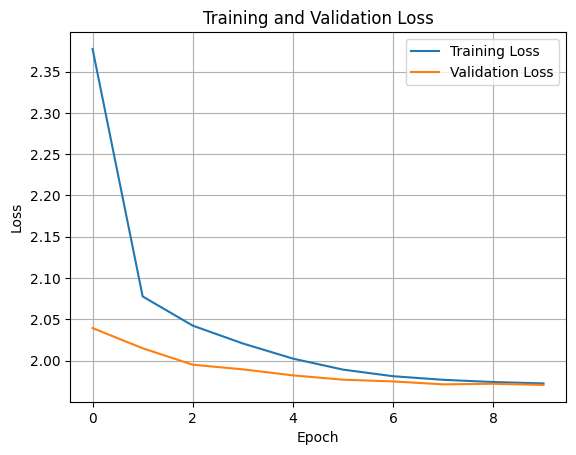

In [16]:

plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss.png')
plt.show()

Final evaluation on test set

In [17]:
test_loss = evaluate(model, dataloader_test, loss_fn)
print(f"\nFinal test loss: {test_loss:.3f}")


Final test loss: 1.971


### Training WITH gradient accumulation

Transformer model with gradient accumulation

In [18]:
model_accumulation = TSPTransformer().to(DEVICE)

In [19]:
def train_epoch_with_accumulation(model: nn.Module, train_dataloader: torch.utils.data.DataLoader, 
                                  optimizer: torch.optim.Optimizer, loss_fn: nn.Module, 
                                  accumulation_steps: int = 4):
    """
    Training loop with gradient accumulation
    
    Args:
        - model: The model to train
        - train_dataloader: Training dataloader
        - optimizer: Optimizer
        - loss_fn: Loss function
        - accumulation_steps: Number of steps to accumulate gradients before updating weights
    
    Returns:
        - Average loss for the epoch
    """
    model.train()
    total_loss = 0
    optimizer.zero_grad()  # Initial gradient zero

    for idx, (src, tgt) in enumerate(train_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        # Forward pass
        output = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

        # Calculate loss and normalize by accumulation steps
        loss = loss_fn(output.reshape(-1, output.shape[-1]), tgt_output.reshape(-1)) / accumulation_steps

        # Backward pass
        loss.backward()

        # Update weights only after accumulating gradients for specified steps
        if (idx + 1) % accumulation_steps == 0:
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update weights
            optimizer.step()
            optimizer.zero_grad()

            # Print progress
            if (idx + 1) % (accumulation_steps * 10) == 0:  # Print every 10 accumulated updates
                print(f'Batch {idx + 1}/{len(train_dataloader)}, Loss: {loss.item() * accumulation_steps:.4f}')

        total_loss += loss.item() * accumulation_steps

    # Handle any remaining gradients at the end of epoch
    if len(train_dataloader) % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    return total_loss / len(train_dataloader)

Setup optimizer and loss function for training

In [20]:
optimizer = torch.optim.AdamW(model_accumulation.parameters(), lr=0.0004, betas=(0.9, 0.98), eps=1e-8, weight_decay=0.01)
loss_fn = nn.CrossEntropyLoss()
training_losses_accumulation = []
validation_losses_accumulation = []
print_every = 2

Gradient accumulation training loop

In [21]:
num_epochs = 7
for epoch in range(1, num_epochs + 1):
    start_time = timer()

    # Training
    train_loss_accumulation = train_epoch(
        model=model_accumulation,
        train_dataloader=dataloader_train,
        optimizer=optimizer,
        loss_fn=loss_fn
    )

    # Validation
    val_loss_accumulation = evaluate(model_accumulation, dataloader_valid, loss_fn)

    end_time = timer()

    # Save losses for plotting
    training_losses_accumulation.append(train_loss_accumulation)
    validation_losses_accumulation.append(val_loss_accumulation)

    # Print each print_every epochs
    if epoch % print_every == 0:
        print(f"Epoch: {epoch}")
        print(f"Train loss: {train_loss_accumulation:.3f}")
        print(f"Validation loss: {val_loss_accumulation:.3f}")
        print(f"Epoch time = {(end_time - start_time):.3f}s")

Epoch: 2
Train loss: 2.040
Validation loss: 1.994
Epoch time = 63.637s
Epoch: 4
Train loss: 1.981
Validation loss: 1.975
Epoch time = 63.770s
Epoch: 6
Train loss: 1.973
Validation loss: 1.971
Epoch time = 63.602s


Plot training and validation losses

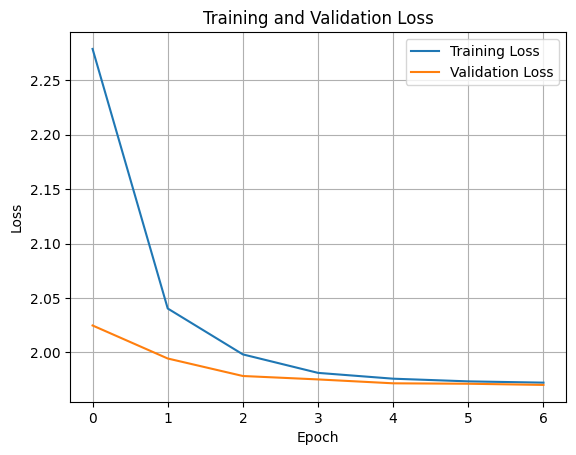

In [22]:
plt.plot(training_losses_accumulation, label='Training Loss')
plt.plot(validation_losses_accumulation, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_accumulation.png')
plt.show()

Final evaluation on test set

In [23]:
test_loss_accumulation = evaluate(model_accumulation, dataloader_test, loss_fn)
print(f"\nFinal test loss: {test_loss_accumulation:.3f}")


Final test loss: 1.971


## Testing

Compute gaps for test set

In [24]:
# Load test set data because Datloader is not usable in compute_gap (it requires a graph)
with open(f"{folder_path}/test_20_DLL_ass4.pkl", 'rb') as f:
    test_datas = pickle.load(f)

In [25]:
def compute_gaps_for_test_set(test_loader: torch.utils.data.DataLoader, model= None, 
                              model_GA = None, device: str = 'cpu'):
    """
    Compute gaps for the test set using the model and model with gradient accumulation
    
    Args:
        - test_loader: Test dataloader
        - model: The trained TSP Transformer model
        - model_GA: The trained TSP Transformer model with gradient accumulation
        - device: The device to run the model on
    
    Returns:
        - A list of dictionaries containing gaps for each sample in the test set
    """
    gaps_list = []
    for data in test_loader:
        gaps = compute_gap(data[0], model=model, model_GA=model_GA, device=device)
        gaps_list.append(gaps)
    return gaps_list

Compute gaps for each method on the test set

In [26]:
gaps_list = compute_gaps_for_test_set(test_datas, model=model, model_GA=model_accumulation, device=DEVICE)

Extract gaps for each method

In [27]:
gaps_greedy = [gaps['greedy'] for gaps in gaps_list]
gaps_random = [gaps['random'] for gaps in gaps_list]
gaps_transformer = [gaps['transformer_tsp'] for gaps in gaps_list]
gaps_transformer_ga = [gaps['transformer_tsp_acc_grad'] for gaps in gaps_list]

Plot boxplots

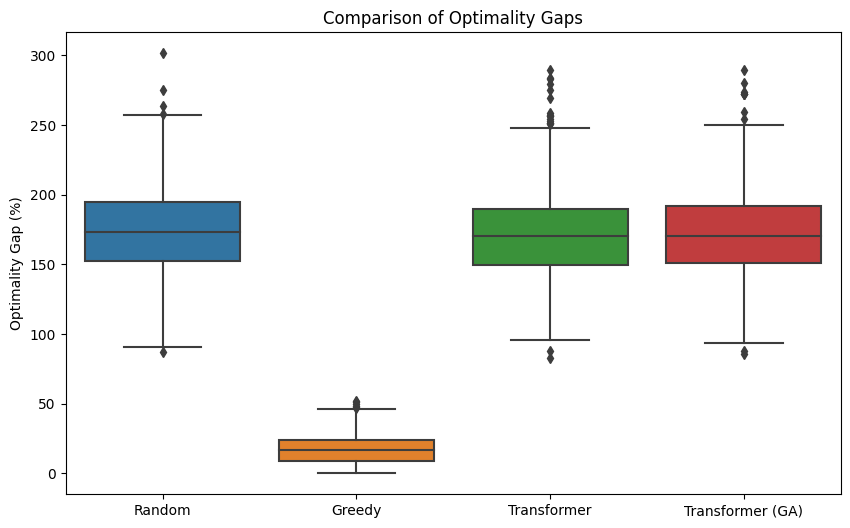

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=[gaps_random, gaps_greedy, gaps_transformer, gaps_transformer_ga])
plt.xticks([0, 1, 2, 3], ['Random', 'Greedy', 'Transformer', 'Transformer (GA)'])
plt.ylabel('Optimality Gap (%)')
plt.title('Comparison of Optimality Gaps')
plt.savefig('algorithm_distr.png')
plt.show()